# English Wikipedia page views 2007 - 2018
This code is made available for re-use under a [CC0 license](https://creativecommons.org/share-your-work/public-domain/cc0/). 


In [93]:
import json
import requests
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [94]:
# Part 1: Retrieving and saving the data

endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'


In [95]:
# Specify paramaters to use for retrieving data
# see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
pagecounts_desktop = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site", # "mobile-site"
                 "granularity" : "monthly",
                 "start" : "2001010100",
                # for end use 1st day of month following final month of data
                 "end" : "2018100100"
                    }
pagecounts_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2001010100",
                # for end use 1st day of month following final month of data
                 "end" : "2018100100"
                    }

# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop", #"mobile-web","mobile-app"
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2018101000'
                        }
pageviews_mobile_web = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2018101000'
                        }
pageviews_mobile_app = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2018101000'
                        }

# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/yourusername',
    'From': 'youremail@uw.edu'
}

In [96]:
# A helper function for making API calls
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [97]:
# Call the endpoints with each of the 5 requests (mobile+desktop for legacy, mobile app+mobile web+desktop for new service)
# Save the output into a file in the data folder
for (endpoint,params) in ((endpoint_legacy,"pagecounts_desktop"),
                          (endpoint_legacy,"pagecounts_mobile"),
                          (endpoint_pageviews,"pageviews_desktop"),
                          (endpoint_pageviews,"pageviews_mobile_web"),
                          (endpoint_pageviews,"pageviews_mobile_app"),
                         ):
    data = api_call(endpoint, eval(params))
    with open('data/'+params+'_200701_201809.json', 'w') as f:
        json.dump(data, f, ensure_ascii=False)


In [98]:
# A helper function for reading in json data and join in Pandas
def read_data(filename):
    """
    Function for reading in data from a file and returning as a pandas dataframe
    """
    with open(filename, 'r') as f:
        a = json.loads(f.read())
    return pandas.DataFrame.from_dict(a['items'])



(105, 5)


,access-site,count,granularity,project,timestamp
0,desktop-site,2998331524,monthly,en.wikipedia,2007120100
1,desktop-site,4930902570,monthly,en.wikipedia,2008010100
2,desktop-site,4818393763,monthly,en.wikipedia,2008020100
3,desktop-site,4955405809,monthly,en.wikipedia,2008030100
4,desktop-site,5159162183,monthly,en.wikipedia,2008040100


In [ ]:
# For each of the 5 files, read in the JSON data using the above function
pagecounts_desktop = read_data('data/pagecounts_desktop_200701_201809.json')
pagecounts_mobile = read_data('data/pagecounts_mobile_200701_201809.json')
pageviews_desktop = read_data('data/pageviews_desktop_200701_201809.json')
pageviews_mobile_app = read_data('data/pageviews_mobile_app_200701_201809.json')
pageviews_mobile_web = read_data('data/pageviews_mobile_web_200701_201809.json')

In [99]:
# Preview the data
pageviews_mobile_app.head()


,access,agent,granularity,project,timestamp,views
0,mobile-app,user,monthly,en.wikipedia,2015070100,109624146
1,mobile-app,user,monthly,en.wikipedia,2015080100,109669149
2,mobile-app,user,monthly,en.wikipedia,2015090100,96221684
3,mobile-app,user,monthly,en.wikipedia,2015100100,94523777
4,mobile-app,user,monthly,en.wikipedia,2015110100,94353925


In [100]:
# rename views colums so they are distinguishable when joined
pagecounts_desktop.rename(index=str, columns={"count": "pagecount_desktop_views"},inplace=True)
pagecounts_mobile.rename(index=str, columns={"count": "pagecount_mobile_views"},inplace=True)
pageviews_desktop.rename(index=str, columns={"views": "pageviews_desktop_views"},inplace=True)
pageviews_mobile_app.rename(index=str, columns={"views": "pageviews_mobile_app_views"},inplace=True)
pageviews_mobile_web.rename(index=str, columns={"views": "pageviews_mobile_web"},inplace=True)

# Example new table
pagecounts_mobile.head()


,access-site,pagecount_mobile_views,granularity,project,timestamp
0,mobile-site,3091546685,monthly,en.wikipedia,2014100100
1,mobile-site,3027489668,monthly,en.wikipedia,2014110100
2,mobile-site,3278950021,monthly,en.wikipedia,2014120100
3,mobile-site,3485302091,monthly,en.wikipedia,2015010100
4,mobile-site,3091534479,monthly,en.wikipedia,2015020100


In [101]:
# Merge datasets together, first within the endpoints

full_pagecounts_data = pagecounts_desktop.merge(pagecounts_mobile, on = 'timestamp', how = 'outer')
full_pageview_data = pageviews_desktop.merge(pageviews_mobile_app, 
                                             on = 'timestamp', 
                                             how = 'outer').merge(pageviews_mobile_web, 
                                                                  on = 'timestamp',
                                                                  how= 'outer')
# Merge data from 2 endpoints into 1 table
full_data = full_pagecounts_data.merge(full_pageview_data,on = 'timestamp', how = 'outer')
# Pull out the month and year
full_data['year'] = full_data['timestamp'].str[:4]
full_data['month'] = full_data['timestamp'].str[4:6]

# Create aggregated columns with mobile app + mobile web and mobile+desktop
full_data['pageviews_mobile_views'] = full_data['pageviews_mobile_app_views'] + full_data['pageviews_mobile_web']
full_data['pagecount_all_views']= full_data['pagecount_desktop_views'] + full_data['pagecount_mobile_views']  
full_data['pageview_all_views']= full_data['pageviews_desktop_views'] + full_data['pageviews_mobile_views']  

# Restrict to only columns we care about
full_data = full_data[['year',
                       'month',
                       'pagecount_all_views',
                       'pagecount_desktop_views',
                       'pagecount_mobile_views',
                       'pageview_all_views',
                       'pageviews_desktop_views',
                       'pageviews_mobile_views'
                      ]].fillna(0)
# Preview data and save to csv
full_data.head(10)
full_data.to_csv('data/en-wikipedia_traffic_200801-201709.csv')

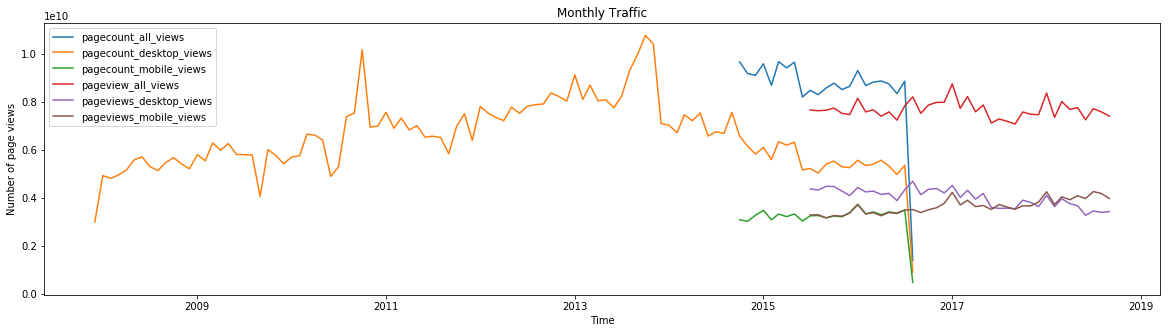

In [136]:
# Section 3: Plotting

# Create datetime column for plotting and set as the index
full_data['day'] = 1
full_data['date'] = pandas.to_datetime(full_data[['year', 'month','day']])
full_data.set_index('date',inplace=True)

#Change zeros to nan so they don't get plotted
full_data[ full_data==0 ] = np.nan

# Plot with labels and axis
plt.figure(figsize=(20,5)) 
plt.plot(full_data[['pagecount_all_views',
                   'pagecount_desktop_views',
                   'pagecount_mobile_views',
                   'pageview_all_views',
                   'pageviews_desktop_views',
                   'pageviews_mobile_views'
                  ]])
plt.legend(('pagecount_all_views',
                   'pagecount_desktop_views',
                   'pagecount_mobile_views',
                   'pageview_all_views',
                   'pageviews_desktop_views',
                   'pageviews_mobile_views'))
plt.title("Monthly Traffic")
plt.xlabel("Time")
plt.ylabel("Number of page views")
plt.savefig('monthlyTraffic.png')
plt.show()